In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Smart campaign definition

In [3]:
CAMPAIGN_DICT = {
    'name': "BasicSmartCampaign",
    
    # Allowed values for both ALPHA_RISK_TYPE and CAMPAIGN_RISK_TYPE

    # 'atr' - ATR(RISK_PERIOD) of alpha/campaign equity risk metric
    # 'atrmax' - Highest(ATR(RISK_PERIOD)) of alpha/campaign equity risk metric
    # 'ddavg' - rolling mean (RISK_PERIOD) of drawdown of alpha/campaign equity 
    # 'ddmax' - rolling maximum (RISK_PERIOD) of drawdown of alpha/campaign equity
    # 'ddq95' - rolling 95% quantile (RISK_PERIOD) of drawdown of alpha/campaign equity    
    'alpha_risk_type': 'atr',
    'alpha_risk_period': 100,
    'alpha_min_risk': 100,

    'campaign_risk_type': 'atrmax',
    'campaign_risk_period': 100,
    'campaign_min_risk': 100,
    
    #
    # Campaign definition
    #
    'alphas': {
        # Single alphas
        '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXO_PutSpread_DynKel_longs_DSP_BandPass__Bullish_2_Sept_7_21': {'tag': ''},
        
        # !! Risk reversal stack V1 + V2
        'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7__hedged': {
            'tag': '',
            'alphas': {
                'ZN_ContFut_Long_Strategy_DSP_BandPass__Bullish_2_Sept_7_custom': 1.0,
                '!NEW_AlphaV1Exposure_HedgedBy_V2_US_ZN_EXOSemiFuture_DynKel_20_60_longs_DSP_BandPass__Bullish_2_Sept_7_Oct_6': 1.0,
            }
        }
    }
}

### Loading smart campaign alphas

In [4]:
import pandas as pd
from smartcampaign import SmartCampaignBase
from smartcampaign.tools import *
import os

#
# Init V1 framework datasource
#
from exobuilder.data.exostorage import EXOStorage
from scripts.settings import *

storage = EXOStorage(MONGO_CONNSTR, MONGO_EXO_DB)



# Loading V1 and V2 alphas
alphas_list = SmartCampaignBase.get_alphas_list_from_settings(CAMPAIGN_DICT)
alphas_series_dict = storage.swarms_data(alphas_list, load_v2_alphas=True)
df_alphas_equities = pd.DataFrame({k: v['swarm_series']['equity'] for k,v in alphas_series_dict.items()})


## Creating customized SmartCampaign

There are 3 main methods for SmartCampaign customization
- calc_alpha_risk(...) - calculates the risk of a particucular alpha equity in dollars
- compose_portfolio(...) - allows you to manage portfolio of alphas, by shutting down or managing alpha weights
- calc_campaign_risk(...) - calculates custom campaign risk 

# Backtesting

In [5]:
#
# Init Smart Campaign
#
scmp = SmartCampaignBase(CAMPAIGN_DICT, df_alphas_equities)

BACKTESTER_SETTINGS = {
    'start_date': datetime.datetime(2014, 1, 1),
    'initial_capital': 50000,
    'target_risk_percent': 0.01,    
}

bt_dict = scmp.backtest(**BACKTESTER_SETTINGS)

                                 MM             Adj Plain      Adj No Reinv   Simple Sum  
NetProfit $                         -10458.92      -10458.92      -12177.48        -794.31
NetProfit %                           -20.92%        -20.92%        -24.35%         -1.59%

MaxDD $                             -19640.37      -19640.37      -21184.21       -6429.19
MaxDD %                               -33.65%        -33.65%        -36.58%        -11.72%

MaxATR $                               544.05         544.05         545.95         198.96
Q95% ATR $                             514.46         514.46         521.02         190.89
Avg ATR $                              437.45         437.45         450.98         166.36

MaxATR %                                1.18%          1.18%          1.21%          0.38%
Q95% ATR %                              1.07%          1.07%          1.15%          0.37%
Avg ATR %                               0.92%          0.92%          0.97%          0.

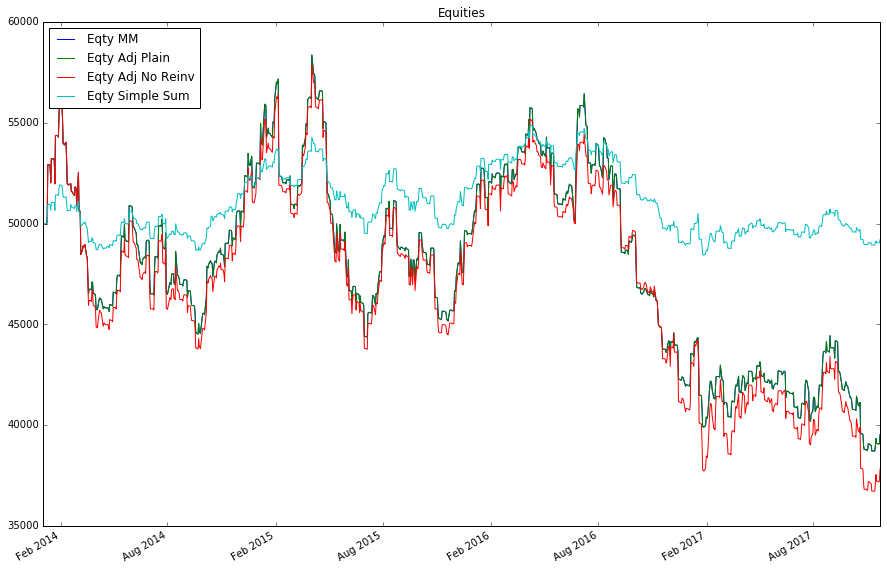

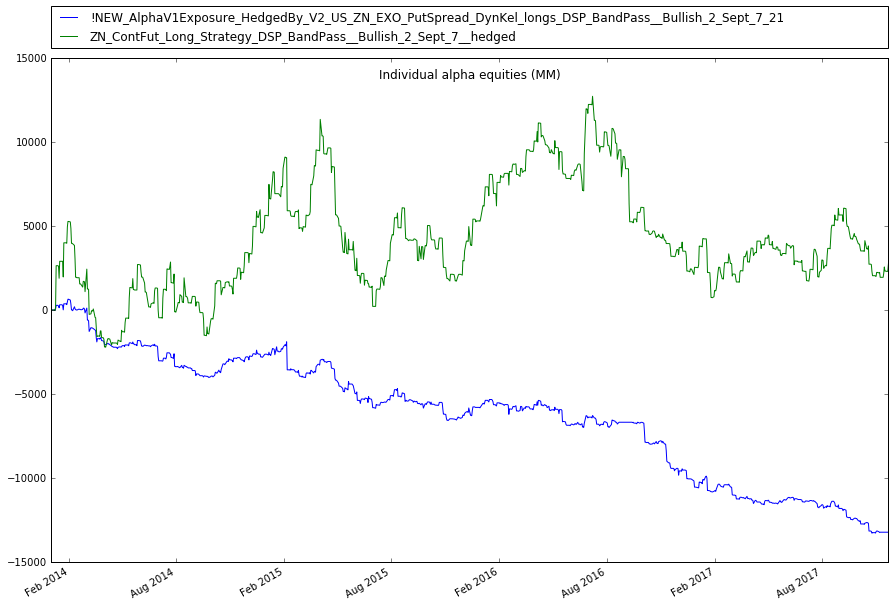

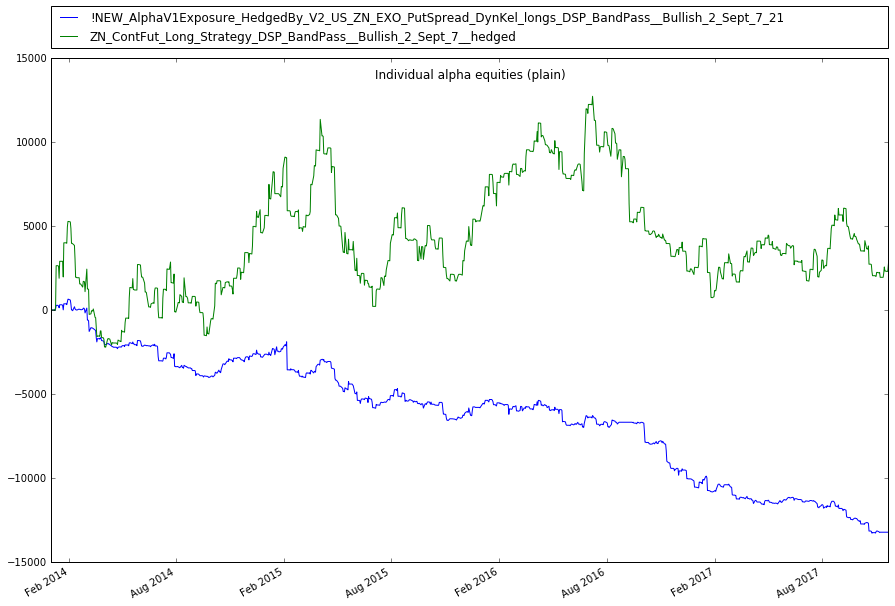

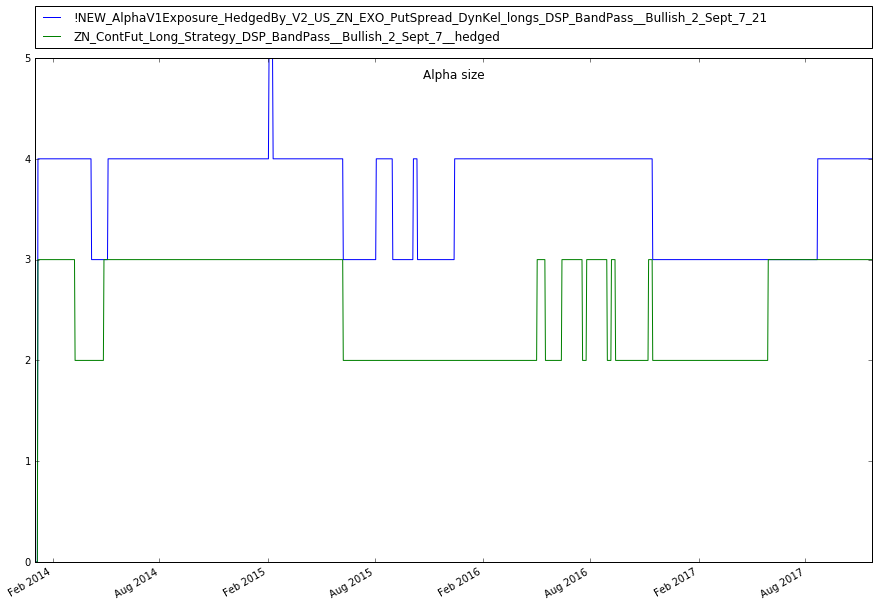

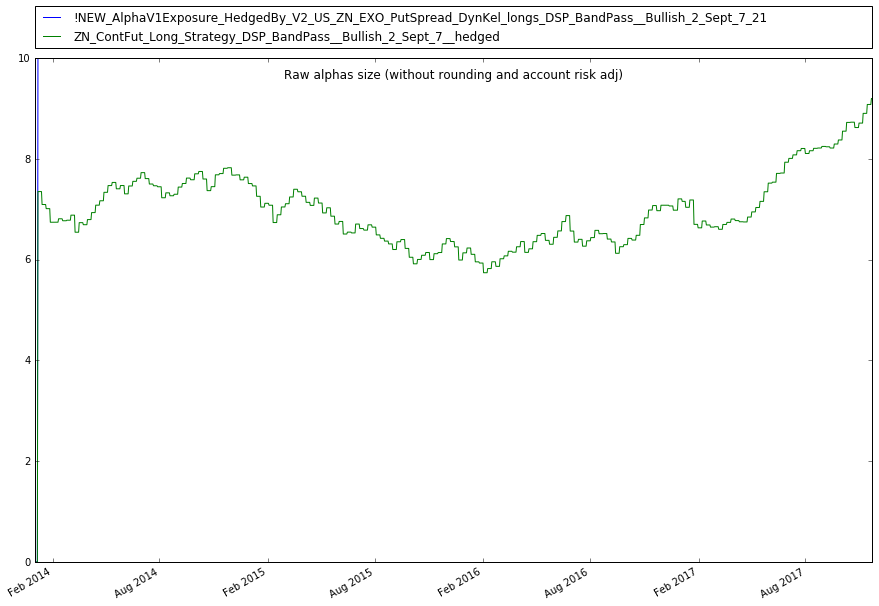

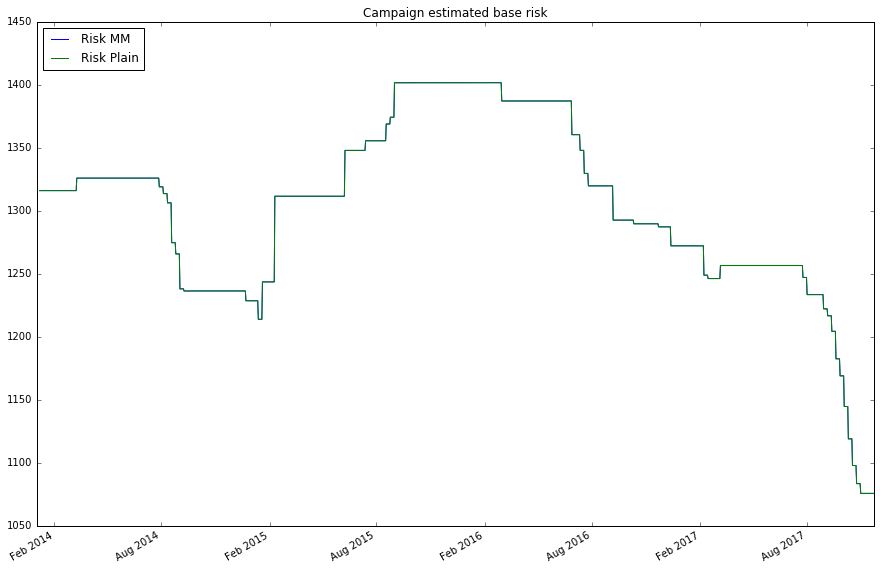

In [6]:
figsize(15, 10)
scmp.report(bt_dict)

#bt_dict['campaign_alphas_size_raw']

# Export to v1 campaign

In [10]:
MONGO_CONNSTR = 'mongodb://localhost'
MONGO_EXO_DB = 'tmldb_v2'

In [11]:
from tradingcore.execution_manager import ExecutionManager
from tradingcore.campaign import Campaign
from exobuilder.data.datasource_mongo import DataSourceMongo
from exobuilder.data.assetindex_mongo import AssetIndexMongo

assetindex = AssetIndexMongo(MONGO_CONNSTR, MONGO_EXO_DB)
datasource = DataSourceMongo(MONGO_CONNSTR, MONGO_EXO_DB, assetindex, futures_limit=10, options_limit=10, exostorage=storage)
exmgr = ExecutionManager(MONGO_CONNSTR, datasource, dbname=MONGO_EXO_DB)


campaign_dict = scmp.export_to_v1_campaign()

In [12]:
cmp = Campaign(campaign_dict, datasource)
exmgr.campaign_save(cmp)

Done


In [13]:
from pymongo import MongoClient

client = MongoClient(MONGO_CONNSTR)
db = client[MONGO_EXO_DB]

mongo_collection = db['campaigns_smart']

scmp.save(mongo_collection)

In [12]:
smcp_loaded = SmartCampaignBase.load_from_v1("BasicSmartCampaign", storage, mongo_collection)

bt_dict_loaded = smcp_loaded.backtest(**BACKTESTER_SETTINGS)

smcp_loaded.report(bt_dict_loaded)

# Adding new Smart Campaign Account

In [14]:
from tradingcore.campaign import Campaign
from tradingcore.account import Account

from tradingcore.moneymanagement import PlainMM, SmartCampaignMM

In [16]:
acct_info = {
    'smart_total_risk_percent': 0.01,
    'smart_equity': 10000,
}

mm_class = SmartCampaignMM(acct_info)

In [17]:
mm_class.get_positions(cmp)

[]

In [19]:
cmp.positions_at_date(datetime.datetime(2017, 10, 23))